In [1]:
%matplotlib notebook
import numpy as np
import numba
from scipy.integrate import odeint
from scipy.linalg import solve_lyapunov, eigvals
from scipy.stats import linregress
import awesomeplot.core as ap

from tqdm import *


In [2]:
apply_filter = np.vectorize(lambda x, f: 1. if x > f else 0.)

nan_filter = np.vectorize(lambda x: 1. if np.isfinite(x) else 0.)

regularized_norm = np.vectorize(lambda x: 1./x if not x == 0. else 1.)

regularized_inv = np.vectorize(lambda x: 1./x if not x == 0. else 0.)

stepfunc = np.vectorize(lambda x, f: 0. if x < f else 1.)

prod = lambda a,b: a * b

In [3]:
def test_convergence(fmax, times, abs_tol=1e-1, inc_crit=0., ts_frac=0.75, talk=0):
    L = len(times)
    slope, intercept, r_value, p_value, std_err = linregress(times[int(ts_frac * L):], np.log(fmax)[int(ts_frac * L):])
    if talk:
        print r"slope {:3f}, intercept {:3f}, r_val {:3f}, p_val {:3f},std_err {:3f}".format(slope, intercept, r_value, p_value, std_err)
    if slope <= inc_crit and fmax[-1] < abs_tol:
        return True
    else:
        return False

In [4]:
class SwingPars(object):
    def __init__(self, sample=1):
        self.sample = sample
        self.dim = 2 * sample
        self.a = 0.1 
        self.p = 1.
        self.k = 8. 
        self.fix_point = np.append(np.arcsin(1. * self.p / self.k), 0)


In [5]:
#@numba.jit()
def rhs_single(y, t):
    return np.append(
        y[pars.sample:], 
        pars.p - pars.a * y[pars.sample:] - pars.k * np.sin(y[:pars.sample] + pars.fix_point[0])
    )

In [6]:
def jacobian(point=[0, 0]):
    return np.array([[0., 1.], [- pars.k * np.cos(point[0] + pars.fix_point[0]), - pars.a]])

In [7]:
def lyapunov(point=[0, 0]):
    return solve_lyapunov(jacobian(point=point).transpose(), - np.diag(np.ones(2)))

In [8]:
def sub_dict_select(somedict, somekeys):
    return dict([ (k, somedict[k]) for k in somekeys if k in somedict])

In [9]:
pars = SwingPars(sample=2000) # mehr fuer BS, sonst runterstellen

In [10]:
L = lyapunov()
lambda_min, lambda_max = sorted(np.real(eigvals(L)))

In [11]:
lambda_min, lambda_max

(5.6298392016449368, 44.692670660556146)

In [12]:
@numba.jit()
def lyapunov_prod(x, p=[0, 0]):
    # x centered around p (i.e. fix point)
    return np.sqrt((x - p).dot(L.dot(x - p)) / (lambda_min * Crho**2))

In [13]:
canvas = ap.Plot(output="paper")
canvas.set_default_colours("discrete")

In [14]:
np.random.seed(42)

In [15]:
R = np.array([np.pi / 3., 5.])
epsilon = np.linspace(1e-4, 1e-1, 21)

# upper bound on Crho
# sphere x^t L x / lambda = (epsilon * Crho)^2
Crho =  1. / R[0] + 1. / R[1]

In [16]:
epsilon

array([ 0.0001  ,  0.005095,  0.01009 ,  0.015085,  0.02008 ,  0.025075,
        0.03007 ,  0.035065,  0.04006 ,  0.045055,  0.05005 ,  0.055045,
        0.06004 ,  0.065035,  0.07003 ,  0.075025,  0.08002 ,  0.085015,
        0.09001 ,  0.095005,  0.1     ])

In [17]:
ic = (1. - 2. * np.random.random(pars.dim))
ic[:pars.sample] *= R[0]
ic[pars.sample:] *= R[1]

In [18]:
x = odeint(func=rhs_single, y0=ic, t=np.arange(0, 500, 0.01))

In [19]:
returned = [test_convergence(fmax=np.abs(x[:, pars.sample + s]), times=np.arange(0, 500, 0.01), talk=0) for s in tqdm(range(pars.sample))]

100%|██████████| 2000/2000 [00:03<00:00, 567.88it/s]


In [20]:
# 
basin_stability = np.mean(returned)
err = np.sqrt(basin_stability*(1 - basin_stability) / pars.sample)

In [21]:
basin_stability = (np.sum(returned) + 0.5) / (pars.sample + 1.) # agresti, croull estimator 
err = np.sqrt(basin_stability*(1 - basin_stability) / (pars.sample + 1))

In [22]:
basin_stability, err

(0.98725637181409298, 0.0025074828669642249)

In [23]:
pars = SwingPars(sample=200) # mehr fuer BS, sonst runterstellen

In [24]:
step = 0.01
times = np.arange(0, 500, step)

In [25]:
ic = (1. - 2. * np.random.random(pars.dim))
ic[:pars.sample] *= R[0]
ic[pars.sample:] *= R[1]

In [26]:
x = odeint(func=rhs_single, y0=ic, t=times)

In [27]:
returned = [test_convergence(fmax=np.abs(x[:, pars.sample + s]), times=times, talk=0) for s in tqdm(range(pars.sample))]

100%|██████████| 200/200 [00:00<00:00, 539.27it/s]


In [28]:
@numba.jit()
def iota_uniform_old(point=[0, 0]):
    px, py = np.abs(point)
    a, b = 2. * R
    return 2. * (px * py + (a - px) * py + px * (b - py)) / (a * b)

In [29]:
@numba.jit()
def iota_uniform_numba(point=[0, 0]):
    #px, py = np.abs(point)
    #a, b = R
    V = 1.
    for r in R:
        V *= 2. * r
    #[max(0, 2. * R[i] - point[i]) for i in range(len(R))]
    erg = 1.
    for i in range(len(R)):
        erg *= max(0, 2 * R[i] - point[i])
    return 2. - erg * 2. / V
    #return 2. - 2. * max(0, 2. * a - point[0]) * max(0, 2. * b - point[1]) / V

In [30]:
def iota_uniform(point=[0, 0]):
    #px, py = np.abs(point)
    #a, b = R
    V = reduce(prod, 2. * R)
    #[max(0, 2. * R[i] - point[i]) for i in range(len(R))]
    return 2. - reduce(prod, stepfunc(2. * R - np.array(point), 0)) * 2. / V
    #return 2. - 2. * max(0, 2. * a - point[0]) * max(0, 2. * b - point[1]) / V

In [31]:
@numba.jit()
def find_idx(vals, e, first=False, less=False, nothing=[]):
    if less:
        idx = np.where(np.array(vals) < e)[0]
    else:
        idx = np.where(np.array(vals) > e)[0]
    #print idx
    if len(idx) is 0:
        return nothing
    else:
        if first:
            return idx[0] 
        else:
            return idx[-1]
    

In [32]:
iota_vals = {}
lyap_vals = {}

for s in tqdm(range(pars.sample)):
    if returned[s]:
        lyap =  [lyapunov_prod(p) for p in np.c_[x[:, s], x[:, s + pars.sample]]]
        iota = [iota_uniform_numba(p) for p in np.c_[x[:, s], x[:, s + pars.sample]]]
        
        for e in epsilon:
            if "{}".format(e) not in lyap_vals.keys():
                lyap_vals["{}".format(e)] = list()
            if "{}".format(e) not in iota_vals.keys():
                iota_vals["{}".format(e)] = list()
            lyap_vals["{}".format(e)].append(step * (find_idx(lyap, e, nothing=np.nan) + 1) )
            iota_vals["{}".format(e)].append(step * (find_idx(iota, e, nothing=np.nan) + 1) )
    else:
        continue

100%|██████████| 200/200 [01:48<00:00,  1.94it/s]


fig2 = canvas.add_lineplot(x=times, lines=lines2, legend=False)
for e in epsilon:
    fig2.axes[0].axhline(y=e, xmin=times[0], xmax=times[-1], c="b")
fig2.axes[0].set_ylim(.8 * epsilon[0], 1.2 * epsilon[-1])


In [33]:
X = sub_dict_select(iota_vals, iota_vals.keys())
Y = sub_dict_select(lyap_vals, lyap_vals.keys())

In [34]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


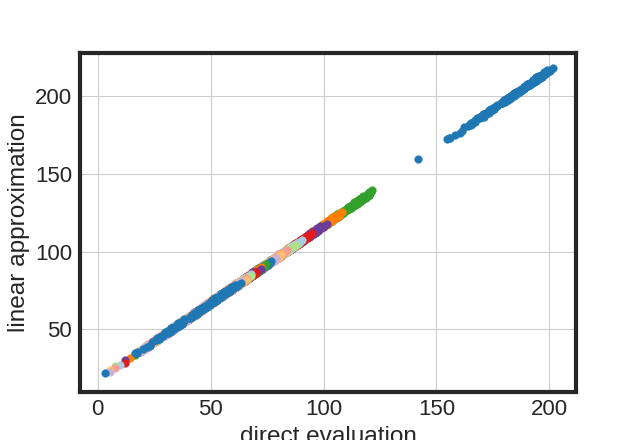

In [35]:
fig3 = plt.figure()
plt.grid()
for e in epsilon:
    plt.scatter(iota_vals["{}".format(e)], lyap_vals["{}".format(e)])
plt.xlabel("direct evaluation")
plt.ylabel("linear approximation")

In [36]:
ftbs = np.zeros([len(times), len(epsilon)])

In [37]:
returns = iota_vals # use iota directly

In [38]:
for i, f in tqdm(enumerate(epsilon), total=len(epsilon)): # epsilon
    for j, t in enumerate(times): # delta T
        returned = (1 - stepfunc(returns["{}".format(f)], t))  # * (1 - stepfunc(obs.fin_abs_values[:, 1], 1e-3))
        ftbs[j, i] = 1. * sum(returned) / pars.sample

100%|██████████| 21/21 [01:14<00:00,  3.51s/it]


In [39]:
ftbs_curves = {r"$\epsilon$={:.0E}".format(epsilon[i]): ftbs[:, i] for i in range(len(epsilon))}
ftbs_curves[r"$\beta$"] = basin_stability * np.ones_like(times)
ftbs_curves[r"$\hat{\mu}_{B}$"] = basin_stability * np.ones_like(times)

In [40]:
np.sort(ftbs_curves.keys())

array(['$\\beta$', '$\\epsilon$=1E-01', '$\\epsilon$=1E-02',
       '$\\epsilon$=1E-04', '$\\epsilon$=2E-02', '$\\epsilon$=3E-02',
       '$\\epsilon$=4E-02', '$\\epsilon$=5E-02', '$\\epsilon$=5E-03',
       '$\\epsilon$=6E-02', '$\\epsilon$=7E-02', '$\\epsilon$=8E-02',
       '$\\epsilon$=9E-02', '$\\hat{\\mu}_{B}$'], 
      dtype='|S16')

In [43]:
filters = np.sort(ftbs_curves.keys())[[3, 2, 1, 0]]
{key: ftbs_curves[key] for key in filters}.keys()

['$\\beta$', '$\\epsilon$=1E-04', '$\\epsilon$=1E-02', '$\\epsilon$=1E-01']

<IPython.core.display.Javascript object>


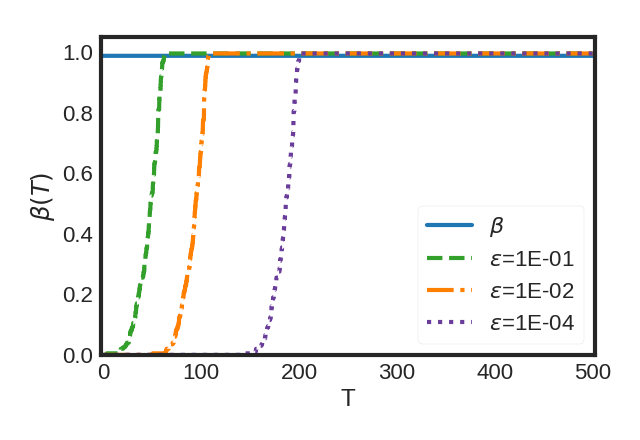

In [45]:
fig4 = canvas.add_lineplot(times, 
                           lines=sub_dict_select(ftbs_curves, filters), 
                           marker="", 
                           labels=["T", r"$\hat{\beta}(T)$"], #r"$\beta(T)$"], 
                           legend=True,
                           #shades={r"$\\beta$": [ftbs_curves[r"$\beta$"]- err, ftbs_curves[r"$\beta$"] + err]}
                          )
fig4.axes[0].set_ylim([0, 1.05])
#fig4.axes[0].set_xlim([0, 150]
fig4.axes[0].fill_between(times, ftbs_curves[r"$\beta$"]- err, ftbs_curves[r"$\beta$"] + err, alpha=0.3)

In [47]:
np.save("ftbs_curves.npy", sub_dict_select(ftbs_curves, filters))

# independence time

In [70]:
canvas.save(fig=fig4, fnames="../figures/swing_ftbs")

In [71]:
deltas = np.logspace(-8, -1, 8, endpoint=True)

In [72]:
step = 0.01
times = np.arange(0, 500, step)

In [73]:
Tind = {}

for delta in tqdm(deltas):
    tc = np.zeros_like(epsilon)
    for i in range(len(epsilon)):
        tc[i] = times[np.where(np.isclose(ftbs[:, i], basin_stability, atol=delta, rtol=err))[0][0]]
              
            #print eps, eps2, np.min(np.abs(bs - ftbs[:, i])), np.abs(bs - ftbs[:, i])
    Tind[r"$\delta$={:.0E}".format(delta)] = tc

100%|██████████| 8/8 [00:00<00:00, 47.41it/s]


In [74]:
Tind

{'$\\delta$=1E-01': array([ 196.64,  117.5 ,  103.9 ,   96.27,   89.98,   85.52,   81.86,
          78.83,   76.45,   74.19,   71.99,   69.85,   68.05,   67.01,
          65.3 ,   63.23,   62.8 ,   60.99,   60.47,   58.75,   58.34]),
 '$\\delta$=1E-02': array([ 200.04,  120.29,  106.85,   99.67,   93.28,   88.83,   84.62,
          82.02,   79.76,   77.52,   75.3 ,   73.09,   71.04,   69.01,
          68.61,   66.57,   66.21,   64.3 ,   63.84,   62.07,   61.73]),
 '$\\delta$=1E-03': array([ 200.5 ,  120.89,  107.49,  100.13,   94.09,   89.63,   86.7 ,
          82.93,   80.67,   78.43,   76.21,   74.  ,   71.8 ,   71.1 ,
          69.51,   67.34,   66.67,   65.09,   64.43,   62.86,   62.21]),
 '$\\delta$=1E-04': array([ 200.5 ,  120.89,  107.49,  100.13,   94.09,   89.63,   86.7 ,
          82.93,   80.67,   78.43,   76.21,   74.  ,   71.8 ,   71.1 ,
          69.51,   67.34,   66.67,   65.09,   64.43,   62.86,   62.21]),
 '$\\delta$=1E-05': array([ 200.5 ,  120.89,  107.49,  100.13,  

In [75]:
filters = np.sort(Tind.keys())[[-1, 3, 0]]
{key: Tind[key] for key in filters}.keys()

['$\\delta$=1E-04', '$\\delta$=1E-08', '$\\delta$=1E-01']

<IPython.core.display.Javascript object>


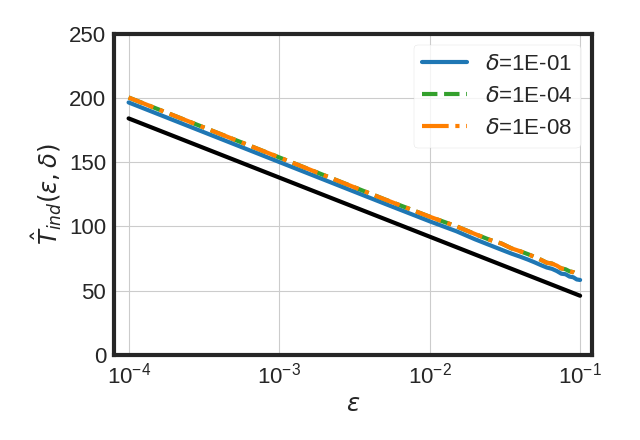

In [76]:
fig5 = canvas.add_lineplot(x=epsilon,
                               lines=sub_dict_select(Tind, filters),
                               labels=[r"$\epsilon$", r"$\hat{T}_{ind}(\epsilon, \delta)$"],
                               sortfunc=lambda x: float(x.split("-")[-1]),
                           grid=True
                               )
fig5.axes[0].set_ylim([0, 250])
fig5.axes[0].set_xlim([0.8 * epsilon[0], 1.2 * epsilon[-1]])
fig5.axes[0].plot(epsilon, 400 * np.log(epsilon ** (-0.05)), "k-")
fig5.axes[0].set_xscale("log")

In [82]:
canvas.save(fig=fig5, fnames="../figures/swing_Tc")

In [77]:
print deltas[0]
np.save("Tind_data_delta{:.0E}.npy".format(deltas[0]), np.c_[epsilon, Tind[r"$\delta$={:.0E}".format(deltas[0])] ])

1e-08


In [78]:
from libescape import BatchSwing
from pik_parallel_tools.batch_framework import hdfutils
import h5py

In [79]:
result_file="simulation_data/results_escape_rate.hdf"
with h5py.File(result_file, mode='r') as h5f:
    brp = hdfutils.init_class_from_hdf5_group(h5f["batch_run_parameters"], BatchSwing)

In [80]:
escape_time = np.zeros([brp.number_of_batches, brp.simulations_per_batch])
print brp.number_of_batches, brp.simulations_per_batch
print brp.deltaT

with h5py.File(result_file, mode='r') as h5f:
    for i in xrange(brp.number_of_batches):
        escape_time[i, :] = np.array(h5f["batch" + str(i)]["escape_time"]) #- brp.deltaT[i]

100 1000
[ 10  10  10  11  11  12  12  12  13  13  14  15  15  16  16  17  18  18
  19  20  21  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  38  39  41  42  44  46  47  49  51  53  55  57  59  62  64  66  69  72
  74  77  80  83  86  90  93  97 100 104 108 112 116 121 126 130 135 140
 146 151 157 163 169 176 182 189 197 204 212 220 228 237 246 255 265 275
 286 296 308 319 332 344 357 371 385 400]


In [81]:
figD = canvas.add_distplot(x=brp.deltaT, y=escape_time, text=False, labels=["T", r"$T_e$"], marker="")
canvas.set_log(figD, log="y")
figD.axes[0].set_ylim([10, 2e5])

<IPython.core.display.Javascript object>

(10, 200000.0)

In [61]:
canvas.save(fig=figD, fnames="../figures/escape_time")

In [62]:
max_time = escape_time.max()
times = np.logspace(-9, np.log10(max_time), 500)

p = np.ones([len(brp.deltaT), len(times)])
p_asymp = np.ones_like(brp.deltaT, dtype=np.float)
p_asymp_err = np.ones_like(p_asymp)

for idx, deltaT in tqdm(enumerate(brp.deltaT), total=len(brp.deltaT)):
    # filter returns 1 if escape_time > t, i.e. trajectory remains at least until time t
    temp = [np.sum(apply_filter(escape_time[idx, :], t)) for t in times]
    # divide by brp.simulations_per_batch
    p[idx, :] = temp * regularized_norm(escape_time.shape[1])
    # calculate n(t) for each interval T
    jumps = np.floor(times / deltaT)
    # invert formula
    p[idx, :] = np.exp(1. * np.log(p[idx, :]) / jumps)
    # average over the last bit
    p_asymp[idx] = np.mean(np.trim_zeros(p[idx, :], "b")[-20:])
    p_asymp_err[idx] = np.std(np.trim_zeros(p[idx, :], "b")[-20:])

  0%|          | 0/100 [00:00<?, ?it/s]/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in divide
100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


In [63]:
# hack for continous line colours
from matplotlib import cycler
from matplotlib.colors import LinearSegmentedColormap, hex2color, Normalize
import matplotlib.cm as cmx

lin_colours_3 = LinearSegmentedColormap.from_list(
    'linear', [(0., 'grey'), (0.5, hex2color('#ffd24d')), (1, canvas.pik_colours.colors[0])]
)
lin_colours_3.set_bad(hex2color('#8e908f'))

cNorm = Normalize(vmin=brp.deltaT[0], vmax=brp.deltaT[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=lin_colours_3)
c = [scalarMap.to_rgba(v) for v in brp.deltaT]

canvas.update_params({
            'axes.prop_cycle': cycler('color', c),
            'image.cmap': lin_colours_3.name
        })

In [64]:
plotp = p.copy()
plotp[np.isnan(plotp)] = 1
plotp[plotp == 0] = np.nan

In [65]:
selection = np.arange(0, 99)

In [76]:
fig6 = canvas.add_lineplot(x=times, 
                           labels=["time t", r"$p(t)$"],
                           lines={r"$\Delta T=${}".format(t): plotp[i, :] for i, t in enumerate(brp.deltaT[selection])}, 
                           sortfunc=lambda x: int(x.split("=$")[-1]),
                           legend=False, 
                           marker=""
                          )

fig6.axes[0].set_xlim([1, max_time*brp.step + 10])
fig6.axes[0].set_ylim([0.88, 1.01])

canvas.set_log(fig6, log="x")

fig6.axes[0].axhline(y=basin_stability - epsilon[0] - deltas[0], xmin=0, xmax= max_time*brp.step + 10, zorder=0, c=canvas.pik_colours.colors[-3])
fig6.axes[0].fill_between(times, 
                          (basin_stability - err - epsilon[0] - deltas[0]) * np.ones_like(times),
                          (basin_stability + err - epsilon[0] - deltas[0]) * np.ones_like(times),
                          edgecolor=canvas.pik_colours.colors[-3], 
                          alpha=0.3,
                          facecolor=canvas.pik_colours.colors[-3], 
                          zorder=0
                         )

<IPython.core.display.Javascript object>

In [126]:
canvas.save(fig=fig6, fnames="../figures/psurv_vs_time")

In [131]:
np.c_[epsilon, Tind[r"$\delta$={:.0E}".format(1e-8)]]

array([[  1.00000000e-04,   2.00500000e+02],
       [  5.09500000e-03,   1.20890000e+02],
       [  1.00900000e-02,   1.07490000e+02],
       [  1.50850000e-02,   1.00130000e+02],
       [  2.00800000e-02,   9.40900000e+01],
       [  2.50750000e-02,   8.96300000e+01],
       [  3.00700000e-02,   8.67000000e+01],
       [  3.50650000e-02,   8.29300000e+01],
       [  4.00600000e-02,   8.06700000e+01],
       [  4.50550000e-02,   7.84300000e+01],
       [  5.00500000e-02,   7.62100000e+01],
       [  5.50450000e-02,   7.40000000e+01],
       [  6.00400000e-02,   7.18000000e+01],
       [  6.50350000e-02,   7.11000000e+01],
       [  7.00300000e-02,   6.95100000e+01],
       [  7.50250000e-02,   6.73400000e+01],
       [  8.00200000e-02,   6.66700000e+01],
       [  8.50150000e-02,   6.50900000e+01],
       [  9.00100000e-02,   6.44300000e+01],
       [  9.50050000e-02,   6.28600000e+01],
       [  1.00000000e-01,   6.22100000e+01]])

<IPython.core.display.Javascript object>


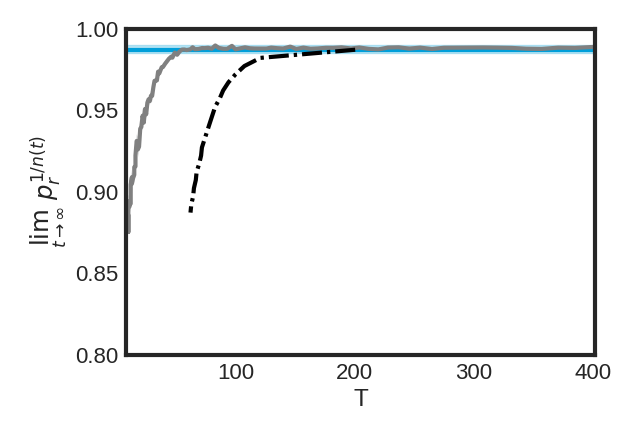

(0.8, 1)

In [132]:
fig7 = canvas.add_lineplot(brp.deltaT,
                              lines={"p_asymp": p_asymp},
                              shades={"p_asymp": [p_asymp - p_asymp_err, p_asymp + p_asymp_err]},
                              labels=[r"T", r"$\lim_{t\rightarrow \infty}\;p(t)$"],
                              marker="",
                              legend=False
                              )
#fig7.axes[0].plot(brp.deltaT,  basin_stability * np.ones_like(brp.deltaT), "k:")

fig7.axes[0].axhline(y=basin_stability, xmin=0, xmax=len(brp.deltaT), zorder=0, c=canvas.pik_colours.colors[-3])
fig7.axes[0].fill_between(times, 
                     (basin_stability - err) * np.ones_like(times),
                     (basin_stability + err) * np.ones_like(times),
                     edgecolor=canvas.pik_colours.colors[-3], alpha=0.3,
                     facecolor=canvas.pik_colours.colors[-3], zorder=0)

fig7.axes[0].plot(Tind[r"$\delta$={:.0E}".format(deltas[0])], (basin_stability - epsilon - deltas[0]), "k-.") # beta -eps - delta

#fig7.axes[0].set_xlim([0, 100])
fig7.axes[0].set_ylim([0.8, 1])



In [133]:
canvas.save(fig=fig7, fnames="../figures/psurv_asymp_bound")